In [1]:
# import graphlab as gl
import matplotlib.pyplot as plt 
import nltk
import pandas as pd
# import stop_words as sw
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import gensim
from gensim.utils import lemmatize, simple_preprocess
import gensim.corpora as corpora
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import spacy, logging, warnings


In [2]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'



- stop word removal
- remove new lines, single quotes
- form unigram and bigram
- apply spacy's lemmatization

In [3]:
topic_size = 10
business = pd.read_json("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json", lines=True)
checkin = pd.read_json("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json", lines=True)
reviews = pd.read_json("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json", lines=True)
tip = pd.read_json("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_tip.json", lines=True)
user = pd.read_json("../data/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json", lines=True)


# reviews = gl.SFrame.read_json('yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json',orient='lines')
# reviews.remove_columns(['business_id','date','review_id','user_id','votes','type'])
# stopwords = gl.text_analytics.stopwords() | set(sw.safe_get_stop_words('en'))
# delimiters=["\r", "\v", "\n", "\f", "\t", " ",'-','.',',','?','&','!',':',';','"','(',')','[',']','{','}','=','/']

In [4]:
reviews.shape

(1125458, 8)

## Distribution of Stars in Review

In [16]:
(reviews.groupby(['stars'])['business_id'].count()/reviews['business_id'].count()*100)

stars
1     9.842393
2     9.128461
3    14.550610
4    30.400335
5    36.078201
Name: business_id, dtype: float64

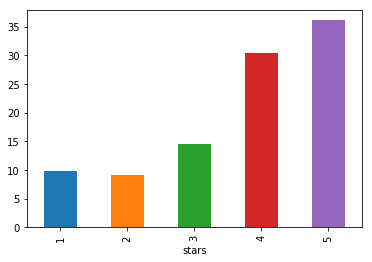

In [11]:
(reviews.groupby(['stars'])['business_id'].count()/reviews['business_id'].count()*100).plot.bar()
plt.show()

## Topic Mining of restaurant reviews

In [5]:
reviews_sample= reviews.sample(n=10000, random_state = 2019)

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'use', 'not', 'would', 'say', 'could', '_', 
                   'be', 'know', 'go', 'get', 'do', 'done', 'many', 'some', 
                    'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make',
                   'want', 'seem', 'run', 'need', 'even', 'right', 'even', 'also', 
                   'may', 'take', 'come'])



In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)  # deacc=True removes accent marks
        yield(sent)
        
             
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out



In [8]:
reviews_list = reviews_sample.text.tolist()
data_reviews = list(sent_to_words(reviews_list))
bigram = gensim.models.Phrases(data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(data_reviews) 
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
doc_topics = lda_model.get_document_topics(corpus)

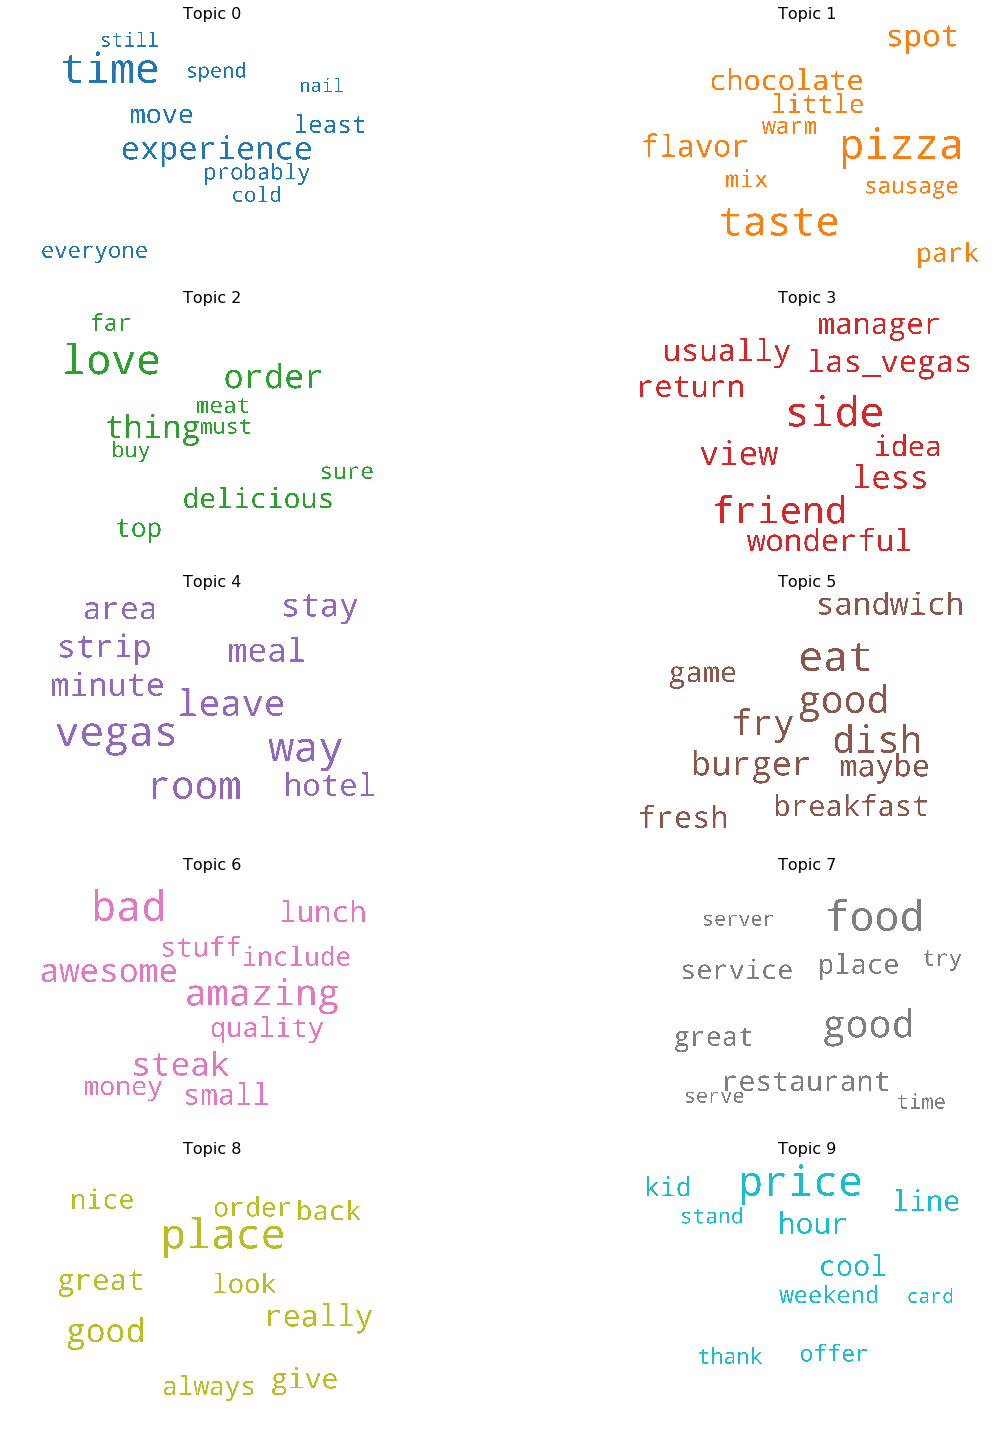

In [15]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Topic Mining of positive and negative reviews

In [8]:
positive_reviews = reviews[reviews['stars'] == 5]
positive_sample = positive_reviews.sample(n=10000, random_state = 2019)

negative_reviews = reviews[reviews['stars'] < 3]
negative_sample = negative_reviews.sample(n=10000, random_state = 2019)


In [10]:
#positive
reviews_list = positive_sample.text.tolist()
data_reviews = list(sent_to_words(reviews_list))
bigram = gensim.models.Phrases(data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(data_reviews) 
# Create Dictionary
id2word_positive = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
positive_corpus = [id2word_positive.doc2bow(text) for text in data_ready]

#negative
reviews_list = negative_sample.text.tolist()
data_reviews = list(sent_to_words(reviews_list))
bigram = gensim.models.Phrases(data_reviews, min_count=3) #removes all words <3 letter counts
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = process_words(data_reviews) 
# Create Dictionary
id2word_negative = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
negative_corpus = [id2word_negative.doc2bow(text) for text in data_ready]

In [13]:
positive_lda_model = gensim.models.ldamodel.LdaModel(corpus=positive_corpus,
                                           id2word=id2word_positive,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
positive_doc_topics = positive_lda_model.get_document_topics(positive_corpus)

negative_lda_model = gensim.models.ldamodel.LdaModel(corpus=negative_corpus,
                                           id2word=id2word_negative,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
negative_doc_topics = negative_lda_model.get_document_topics(negative_corpus)

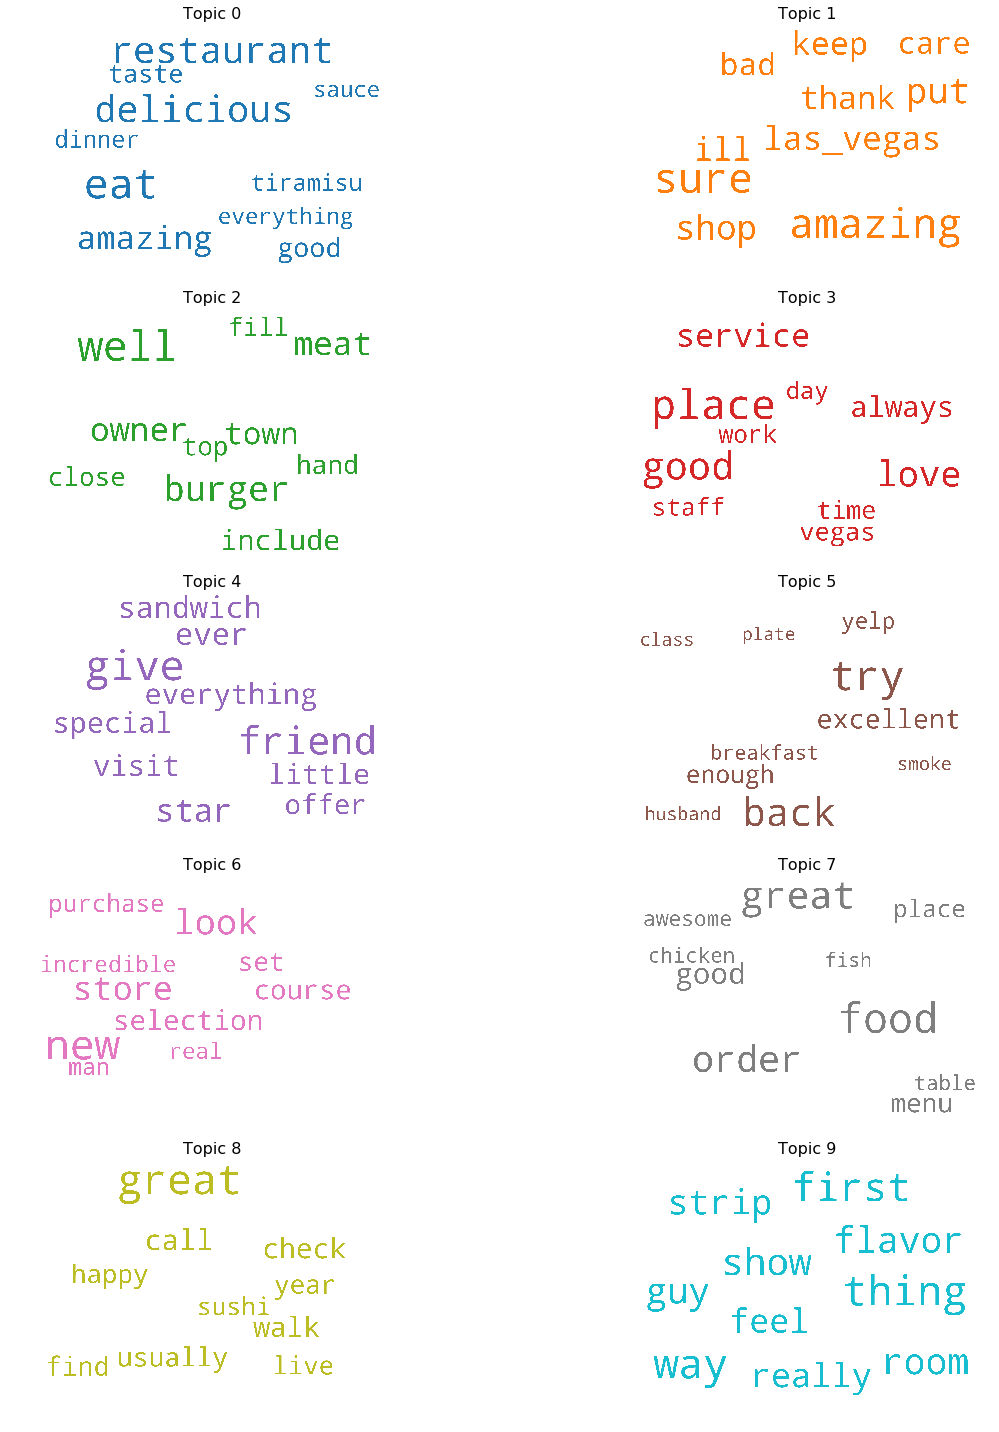

In [14]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = positive_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

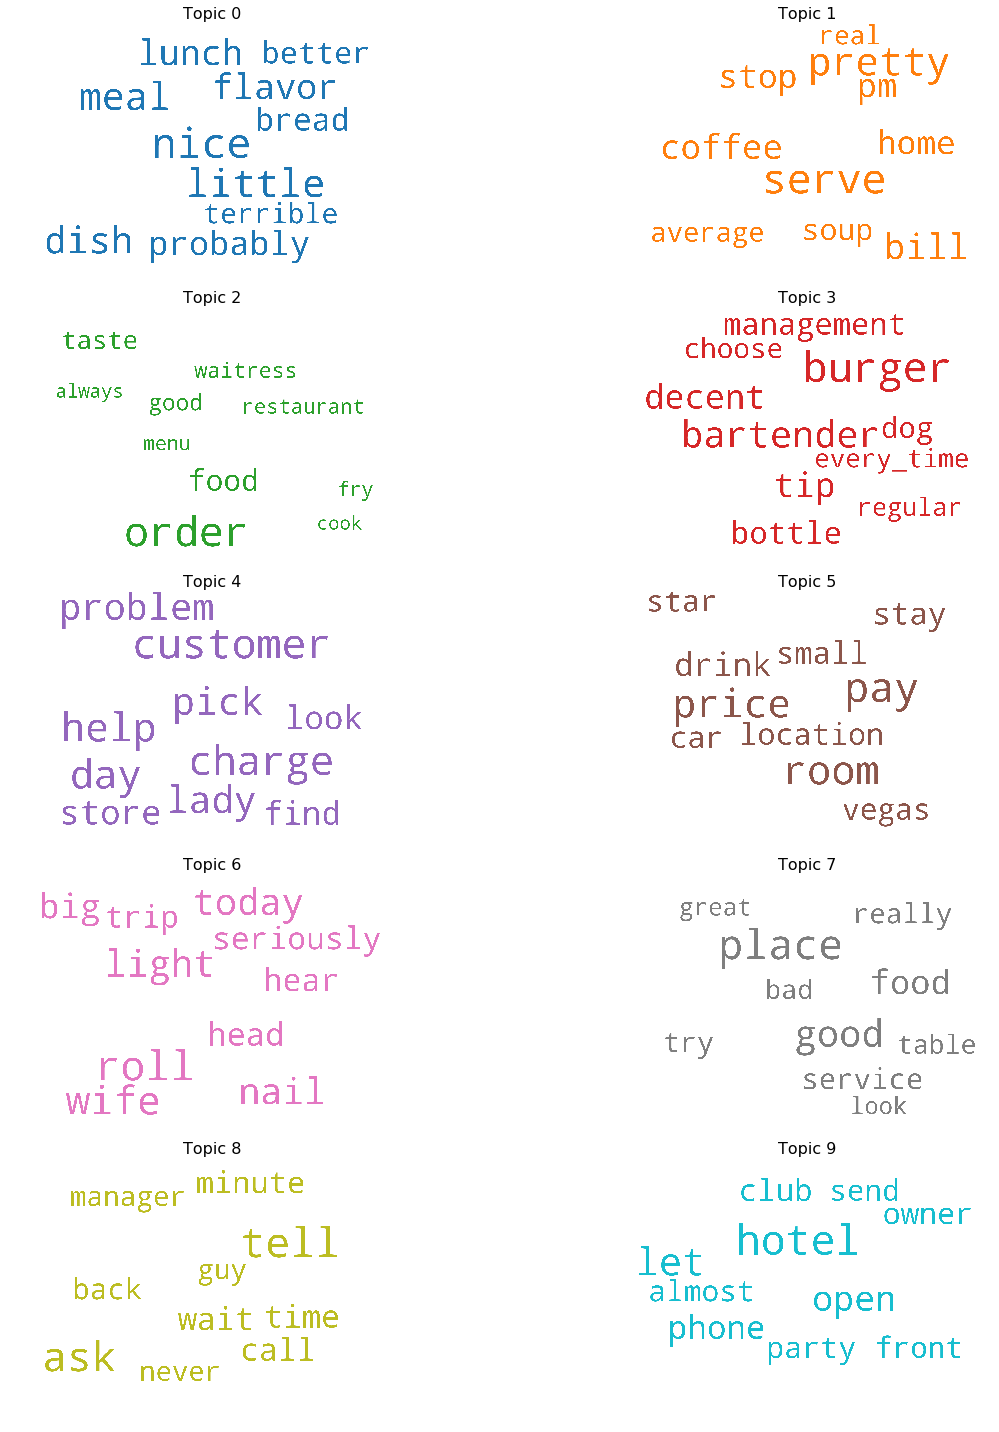

In [15]:

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = negative_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()